# Trajectory Reconstruction



## Description 

You have been provided with three .CSV files containing various pre-processed data. The three .CSV files provided have
the following information: 

1. “Boundary.csv”: The outer boundary of the region of interest (e.g., Walls), (format: x, y)

2. “estWifi.csv”: A collection of time-stamped and preprocessed WiFi-based location estimates, (format: time, x, y)

3. “estInertial.csv”: A collection of pre-processed inertial data, (format: time, heading, step length) 

        a. Heading estimates are in radians and are clockwise from north (i.e., y-axis in this scenario)

        b. Step length estimates are in meters. 

Your task is to estimate/try to reconstruct the user’s trajectory. Feel free to use whatever combination of the datasets
you would like (e.g., only Wi-Fi, only inertial, both). 

Please provide a plot of linked (x,y) points which represent the trajectory (t, x, y) at time intervals of: t = 0, 1, 2, 3, …, etc.

Some guidelines: 

1. Plot the data you intend to work with (e.g., Wi-Fi, inertial, both) until you have gained an understanding of them

2. Briefly describe an algorithmic approach one could take (e.g., flowchart, point-form, pseudocode)

3. Using the programming language of your choice, read in the CSV file data and try to implement your scheme, 

        a. Please add some comments to your code so that it is clear what you are attempting to do,

        b. Please plot your resulting trajectory estimates 

4. Time permitting, you will have implemented a trajectory estimation scheme; however, your scheme may currently not work in real-time. If it does not, please discuss a possible approach that could be taken to adapt your algorithm so that it can work in real-time. 

Please provide written responses to guideline numbers 1-4. 

## Import data

In [1]:
import pandas as pd
import numpy as np
from numpy import linalg as LA

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import scipy.stats

import time

In [2]:
# import data -- outer boundary of the region of interest
boundary = pd.read_csv("./boundary.csv")
#boundary.head()

In [3]:
# import data -- time stamps and wifi-based location estimates
wifi_data = pd.read_csv("./estWifi.csv")
#wifi_data.head()

In [4]:
# import data -- pre-processed intertial data (heading and step length)
imu_data = pd.read_csv("./estInertial.csv")
#imu_data.head()

In [5]:
imu_data.isnull().values.any() # check for nan

False

In [6]:
wifi_data.isnull().values.any()

False

At first, let me assume the data are sampled equally in time, for example, the time interval for inertial data may be 1 second and the time interval for wifi data is 5 seconds. And the start times of sampling are the same.

In [9]:
boundary_df = boundary.values

imu_measurements = imu_data.values

wifi_loc = wifi_data.values

## Raw data visualization

In the following, I convert the inertial data to (x,y) and plot the locations based on wifi and inertial without any filtering or data processing, respectively. The codes are commented because they are not improtant. I just want get a sense of the data.

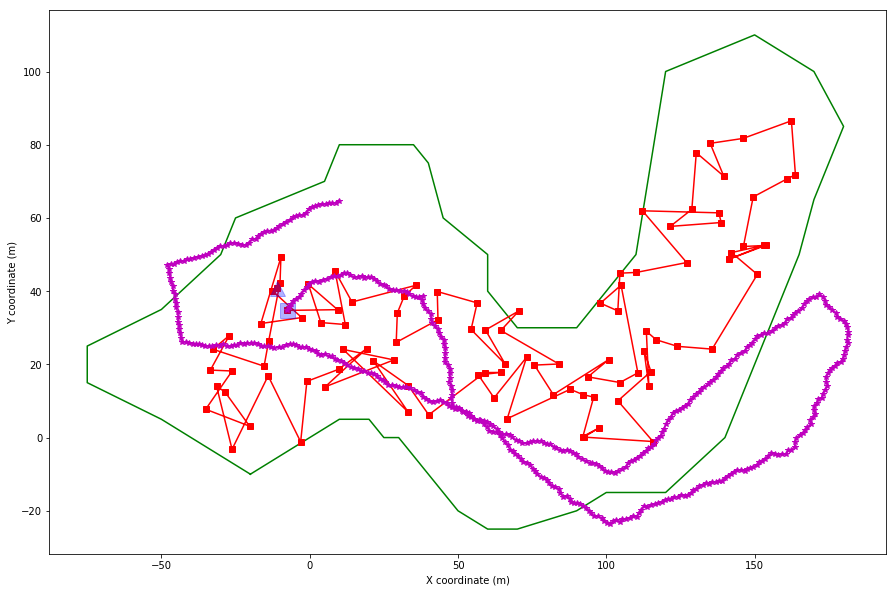

In [46]:
"""
def imu2xyloc(curr_x, curr_y, heading, step_length):
    next_x = curr_x + step_length * np.sin(heading)
    next_y = curr_y + step_length * np.cos(heading)
    return next_x, next_y

loc = np.zeros((imu_data.shape[0], 3))

loc[0,0] = imu_data['time'][0]
loc[0,1], loc[0,2] = wifi_data.x[0], wifi_data.y[0]
for i in range(1,imu_data.shape[0]):
    loc[i,0] = imu_data['time'][i]
    loc[i,1], loc[i,2] = imu2xyloc(loc[i-1,1], loc[i-1,2], imu_data['Heading (rad)'][i-1], imu_data['StepLength (m)'][i-1])

plt.plot(boundary.X, boundary.Y, color='g')
plt.plot(wifi_data.x, wifi_data.y, color='r', marker='s')
# start location - square
plt.plot(wifi_data.x[0], wifi_data.y[0], color='b', markersize=15, marker='s', alpha = 0.3)
# end location - triangle
plt.plot(wifi_data.x[wifi_data.shape[0]-1], wifi_data.y[wifi_data.shape[0]-1], color='b', markersize=15, marker='^', alpha = 0.3)
plt.plot(loc[:,1], loc[:,2], color='m', marker='*')
plt.xlabel('X coordinate (m)')
plt.ylabel('Y coordinate (m)')
plt.show()
"""

The red squares show the locations based on wifi.

The magenta crosses are the locations based on inertial.

The green polygon is the boundary.

Some locations from wifi and lots of locations from inertial are out of the boundary.

### Particle Filter

In the following, **particle filtering (PF)** with **sequential importance resampling (SIR)** and **interior/exterior checking** is used for this indoor localization task.

In [47]:
# a particle filter for 2D 

class ParticleFilter2D :
    """
    Initialize particle filter
    Inputs: 
        - init_location: in 2D
        - num_particles: max number of particles
        - thres: resample threshold. If the total number of particles fall below num_particles*thres, resample
        - mpolygon: boundary
        - s: seed
    Output:
        None
    """
    def __init__(self, init_location, num_particles, mpolygon, thres = 0.5, s=20):
        self.N = 0
        self.x = []
        self.y = []
        self.w = []
        self.thres = thres * num_particles
        self.map = mpolygon
        self.num = num_particles
        np.random.seed(s) #generate same random number by using the same seed
        
        exitFlag = True
        while exitFlag:
            x = init_location[1] + np.random.uniform(-10, 10) #np.random.normal(init_location[1],20)
            y = init_location[2] + np.random.uniform(-10, 10) #np.random.normal(init_location[2],20)
            point = Point(x, y)
            polygon = Polygon(self.map)
            if polygon.contains(point):
                self.x = np.append(self.x, x)
                self.y = np.append(self.y, y)
                self.N += 1
            if self.N == self.num:
                self.w = np.zeros(self.num) + 1/self.N
                exitFlag = False
        print("random initialize")
        

    """
    Prediction step
    Inputs:
        - dp: step length
        - dp_sigma: standard deviation of step length. The step length is Gaussian distributed N(dp, dp_sigma)
        - heading: heading in global frame
        - heading_sigma: standard deviation of heading angle in radian
    Output:
        None
    """

    def predict(self, dp, dp_sigma, heading, heading_sigma):
        self.N = int(self.N)
        for i in range (0, self.N):
            dp_rand = np.random.normal(dp, dp_sigma)
            theta = np.random.normal(heading, heading_sigma) # heading + np.random.uniform(-heading_sigma/2, heading_sigma/2) #np.random.normal(heading, heading_sigma)
            self.x[i] += dp_rand*np.sin(theta%(2*np.pi))
            self.y[i] += dp_rand*np.cos(theta%(2*np.pi))
        
    """
    Update step: if a particle is outside of the boundary, set its weights to zero. Normalize the weights so that the
    sum weight is one. Resample if the number of particles drops below max number of (particles x thres)
    """
    def update(self):
        index = []
        self.N = int(self.N)
        for i in range (0, self.N):
            point = Point(self.x[i],self.y[i])
            polygon = Polygon(self.map)
            if polygon.contains(point):
                self.w[i] = 1
            else:
                self.w[i] = 0
                index = np.append(index, i)   
                
        self.x = np.delete(self.x, index)
        self.y = np.delete(self.y, index)
        self.w = np.delete(self.w, index)
        self.N = int(len(self.x))
        self.w = self.w/self.N
        
        if self.N == 0:
            self.reinitialize()
        elif self.N > 0 and self.N < self.thres:
            self.resample()
            
    """
    update_wifi_SIR: the wifi locations are used as measurements to update/correct the predicted locations.
                     SIR is used to update the weights.
    """
    def update_wifi_SIR(self, wifi_loc, dis_std = .1):
        dis = []
        for i in range (0, self.N):
            dis = np.append( dis, LA.norm([wifi_loc[1]-self.x[i], wifi_loc[2]-self.y[i]]) )
            
        dis_mean = np.mean(dis)
        
        for i in range (0, self.N):
            self.w[i] *= scipy.stats.norm(0, dis_std).pdf(dis_mean - dis[i])
            
        self.w += 1.e-300      # avoid round-off to zero
        self.w = self.w/np.sum(self.w)
        
        


    """
    Resample: regenerate particles according to the weights and multinomial distribution. If no particle left, 
    reinitialize.
    """
    def resample(self):
        n = np.random.multinomial(self.num, self.w)
        x_rsp = []
        y_rsp = []
        for i in range(0, n.shape[0]):
            for j in range(0, n[i]):
                x_rsp = np.append(x_rsp, self.x[i])
                y_rsp = np.append(y_rsp, self.y[i])

        self.x = x_rsp
        self.y = y_rsp
        self.N = self.num
        self.w = np.zeros(self.num) + 1/self.N
        print("resample")
        
        
    """
    Reinitalize: randomly initalize max # of particles to be evently distributed in the corridor. 
    This is used either when you do not know the initial location or all particles die. 
    """
    def reinitialize(self):
        exitFlag = True
        while exitFlag:
            x = np.random.uniform(np.min(self.map[:,1]),np.max(self.map[:,1]))
            y = np.random.uniform(np.min(self.map[:,2]),np.max(self.map[:,2]))
            point = Point(x, y)
            polygon = Polygon(self.map)
            if polygon.contains(point):
                self.x = np.append(self.x, x)
                self.y = np.append(self.y, y)
                self.N += 1
            if self.N == self.num:
                self.w = np.zeros(self.num) + 1/self.N
                exitFlag = False
        print("reinitialize")
        print()

In [49]:
# Hyperparameters is the algorithm
sigma_heading = np.pi/8 # standard deviation of heading angle in radian
sigma_stepLength = 0.12 #imu_data['StepLength (m)'][i-1]/9

num_particle = 2000 # tune this parameter

thres = 0.7 #resample threshold

guessed_loc = np.zeros((imu_measurements.shape[0],3)) 
guessed_loc[0,:] = wifi_loc[0,:] # initilization

pf = ParticleFilter2D(wifi_loc[0,:], num_particle, boundary_df, thres)

t = time.time()
for i in range(1, imu_measurements.shape[0]): #imu_loc.shape[0]
    if (i%50==0):
        print("iteration:", i)
    
    pf.predict(imu_data['StepLength (m)'][i-1], sigma_stepLength, imu_data['Heading (rad)'][i-1], 
               sigma_heading)

    if (i%5 == 0):
        pf.update_wifi_SIR(wifi_loc[int(i/5),:])

    pf.update()
    guessed_loc[i,:] = [imu_measurements[i,0], np.sum(np.multiply(pf.x, pf.w)), np.sum(np.multiply(pf.y, pf.w))]
        
    #print(guessed_loc[i,:])    
        
    
elapsed = time.time() - t
print("elapsed time: ", elapsed)

random initialize
iteration: 50


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


iteration: 100
iteration: 150
resample
resample
resample
iteration: 200
resample
resample
resample
resample
resample
iteration: 250
iteration: 300
iteration: 350
iteration: 400
resample
resample
resample
resample
resample
resample
resample
resample
resample
resample
resample
resample
resample
resample
resample
iteration: 450
resample
iteration: 500
elapsed time:  216.2993185520172


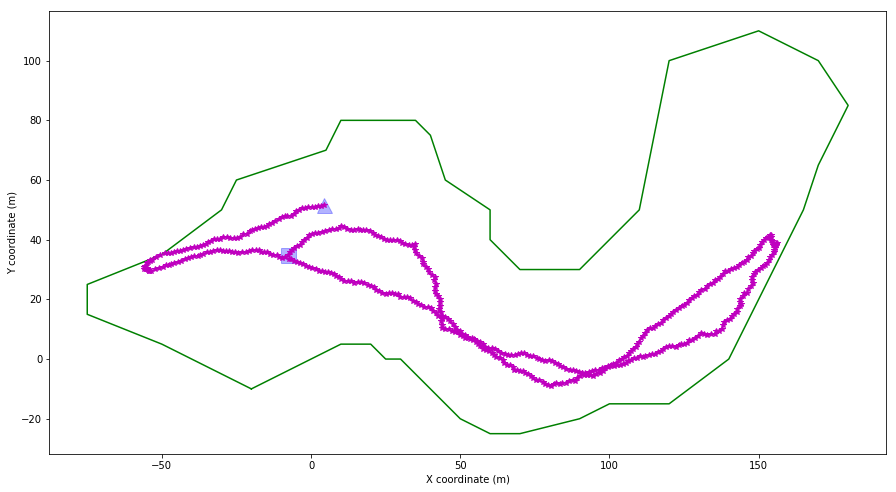

In [51]:
plt.plot(boundary.X, boundary.Y, color='g')
#plt.plot(wifi_data.x, wifi_data.y, color='r', marker='s')
# start location - square
plt.plot(guessed_loc[0,1], guessed_loc[0,2], color='b', markersize=15, marker='s', alpha = 0.3)
# end location - triangle
plt.plot(guessed_loc[guessed_loc.shape[0]-1,1], guessed_loc[guessed_loc.shape[0]-1,2], color='b', markersize=15, marker='^', alpha = 0.3)
plt.plot(guessed_loc[:,1], guessed_loc[:,2], color='m', marker='*')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X coordinate (m)')
plt.ylabel('Y coordinate (m)')
plt.show()

[//]: # (Image References)

[image1]: ./res1.png

**By changing hyperparameters (sensor noise standard deviations and/or number of particles), the estimated trajectory will change.**

![alt text][image1]

## Responses to guidelines

    1. The locations from wifi and inertial sensor, as well as the estimated trajectory, i.e., the indoor localization result, using wifi, inertial and boundary are plotted above.

    2. The Particle Filter with sensor fusion is described below:

        Inputs:
            heading and step length from inertial sensor
            wifi location
            time index
        Outputs:
            estimated location for each time step

        Algorithm:

            1) Particle filter initialization based on the start location from wifi (uniform distribution)

            2) Particle filter prediction based on motion (step length and heading) according to Gaussian distribution

            3) Particle filter update
                if mod(time index,5) == 0
                    Particle filter update using wifi location based on SIR and interior/exterior checking given the boundary
                else
                    Particle filter update given the boundary

            4) if number of particles < threshold: Resample

            5) if number of particles == 0: Reinitialize

            6) Repeat 2) to 5) 
        
    3. Python 3 is used as the programming language. Libaries/APIs such as ``shapely`` (interior/exterior checking given boundary), ``numpy``, ``scipy`` are used. Comments have been added to the code. The estimated trajectory is plotted at the end.

    4. It takes approx. 0.4 s for one epoch when the number of particles is 2000 on my laptop (Core i7 2.5 GHz CPU with 16 GB RAM). Fewer number of particles can save computational time.


## Discussion

    1. The sensor noise w.r.t. the wifi location and inertial data is not known. It is hard to set the standard deviation/variance of heading, step length and wifi location in the Gaussian distributions in the particle filter. The standard deviation of heading and step length are used in the motion model. The standard deviation of wifi location is used in the SIR. These parameters influence the estimation result because they imply the accuracy of the corresponding sensor, i.e., it tells us which sensor we can trust more.
    
    2. The parameters such as number of particles, noise standard deviations, threshold value should be tuned.
    
    3. The result cannot be evaluated because the ground truth is not provided.
    
    4. Particle filter with sensor fusion reduces the drifting error of PDR using inertial data only.
    
    

## References

WIFI + Inertial + Particle Filter + Sensor Fusion

H. Zou, Z. Chen, H. Jiang, L. Xie and C. Spanos, "Accurate indoor localization and tracking using mobile phone inertial sensors, WiFi and iBeacon," 2017 IEEE International Symposium on Inertial Sensors and Systems (INERTIAL), Kauai, HI, 2017, pp. 1-4.
doi: 10.1109/ISISS.2017.7935650
URL: http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7935650&isnumber=7935648

Particle Filter

https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/12-Particle-Filters.ipynb
    
